In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import re
import time
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import textwrap
import scipy.stats as stats

from scipy import stats
import scipy
from functools import partial

import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True})
sns.set_palette(sns.color_palette("Set1", 12))
#sns.set_context("paper")
fontsize = 12
params = {'legend.fontsize': fontsize,
  'figure.figsize': (18, 15),
  'axes.labelsize': fontsize,
  'axes.titlesize':fontsize,
  'axes.edgecolor':"0.3",
  'xtick.labelsize':fontsize,
  'ytick.labelsize':fontsize,
  'legend.fontsize':10,
  'font.size':fontsize,
  'font.family':'serif'}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 

#plt.style.use('ggplot')
%matplotlib inline

from tqdm.notebook import tqdm
import pandas as pd
from pathlib2 import Path
import os

Using matplotlib backend: Qt5Agg


In [2]:
import sys
sys.path.append('../')

from metric_store import save_metrics, save_metric, load_metrics, get_metric_names, load_metric
from network_metrics import prepare_metric
from pipeline.pipeline import load_config

In [3]:
config_name = "pipeline.config"
config = load_config(config_name)

In [4]:
from corr_network import load_data, get_available_mask
data = load_data(config)
available_mask = get_available_mask(data)

In [5]:
metric_names = ['input_data/MSLP_preproc']
for metric_name in metric_names:
    config.metrics_plot_options['metric_name'] = metric_name
    metric = load_metric(config, metric_name)
    metric = prepare_metric(metric_name, metric, available_mask)
    print(metric_name, metric.shape, config.metric_dimension[metric_name])    

input_data/MSLP_preproc (36, 69, 113960) 2D


In [6]:
prefix = 'network_metrics'
metric_names = list(get_metric_names(config, prefix = prefix).keys())
metric_names

['network_metrics/LCC_w',
 'network_metrics/GCC_w',
 'network_metrics/degree_w',
 'network_metrics/EVC_w',
 'network_metrics/closeness_w',
 'network_metrics/LCC_0.9',
 'network_metrics/GCC_0.9',
 'network_metrics/degree_0.9',
 'network_metrics/EVC_0.9',
 'network_metrics/closeness_0.9',
 'network_metrics/LCC_0.95',
 'network_metrics/GCC_0.95',
 'network_metrics/degree_0.95',
 'network_metrics/EVC_0.95',
 'network_metrics/closeness_0.95']

In [52]:
metric_names = list(get_metric_names(config, prefix = 'probability_for_metrics').keys())
main_metric_names = ['degree_w', 'closeness_w', 'LCC_w', 'EVC_w', 'MSLP'] #, 'MSLP_preproc' 'degree_0.9', 
#main_metric_names = ['degree_w', 'LCC_w', 'EVC_w', 'MSLP']
selected_metric_names = []
for metric_name in metric_names:
    for subname in main_metric_names:
        if metric_name.endswith(subname) and metric_name.find('diff_metrics') == -1:
            selected_metric_names += [metric_name]
            break
print(selected_metric_names)

['probability_for_metrics/network_metrics/LCC_w', 'probability_for_metrics/network_metrics/degree_w', 'probability_for_metrics/network_metrics/EVC_w', 'probability_for_metrics/network_metrics/closeness_w', 'probability_for_metrics/input_data/MSLP']


In [57]:
track_size = 8
data = np.load('../cyclones_events.npz')
cyclone_events = data[f'cyclone_events_{track_size}']

metric_names = selected_metric_names.copy()
metrics = []
signs_metric = {
    'probability_for_metrics/input_data/MSLP': False, 
    'probability_for_metrics/network_metrics/LCC_w': True, 
    'probability_for_metrics/network_metrics/degree_w': False, 
    'probability_for_metrics/network_metrics/EVC_w': False,
    'probability_for_metrics/network_metrics/closeness_w': True,
    #'probability_for_metrics/network_metrics/degree_0.9': False,
}
for metric_name in metric_names:
    config.metrics_plot_options['metric_name'] = metric_name
    metric = load_metric(config, metric_name).astype('float32')
    metric = metric if signs_metric[metric_name] else 1 - metric
    metric = -np.log10(metric + 1e-10)
    metrics.append(metric)
    print(metric_name, metric.shape) # , config.metric_dimension[metric_name]

probability_for_metrics/network_metrics/LCC_w (36, 69, 113960)
probability_for_metrics/network_metrics/degree_w (36, 69, 113960)
probability_for_metrics/network_metrics/EVC_w (36, 69, 113960)
probability_for_metrics/network_metrics/closeness_w (36, 69, 113960)
probability_for_metrics/input_data/MSLP (36, 69, 113960)


In [54]:
def compute_weighted_sum(weights, metrics):
    weighted_metric = metrics[0] * weights[0]
    for i in range(1, len(metrics)):
        weighted_metric += metrics[i] * weights[i]
    return weighted_metric

def compute_contigency_table(metric, cyclone_events, metric_thr = 1):
    predicted_events = (metric > metric_thr)

    #d = np.sum(predicted_events & cyclone_events)
    #b = cyclone_events.sum() - d
    #c = predicted_events.sum() - d
    #a = (cyclone_events.size - cyclone_events.sum()) - c
    #return np.array([[a, b], [c, d]])
    
    not_nan_mask = ~np.isnan(metric)
    tn = np.sum(~predicted_events & ~cyclone_events & not_nan_mask)
    fn = np.sum(~predicted_events &  cyclone_events & not_nan_mask)
    fp = np.sum( predicted_events & ~cyclone_events & not_nan_mask)
    tp = np.sum( predicted_events &  cyclone_events & not_nan_mask)

    return np.array([[tn, fn], [fp, tp]])

from functools import partial

def compute_g_stat(contigency_table):
    from scipy.stats import chi2_contingency
    a, b, c, d = contigency_table.flatten()
    if ((a == 0) and (b == 0)) or ((c == 0) and (d == 0)):
        g_stat = p_val = np.nan
    else:
        g_stat, p_val, dof, expctd = chi2_contingency(contigency_table, lambda_="log-likelihood", correction=False)
    return g_stat

def compute_quality(weights, metrics):
    weighted_metric = compute_weighted_sum(weights, metrics)
    contigency_table = compute_contigency_table(weighted_metric, cyclone_events)
    g_stat = compute_g_stat(contigency_table)
    return -g_stat

In [55]:
def show_progress_pbar(x, pbar):
    f = compute_quality_all(x)
    pbar.set_description(f"Current value: {f:.2f} x = {x}")
    pbar.update(1)

In [58]:
compute_quality_all = partial(compute_quality, metrics=metrics)
max_iter = 500
show_progress = partial(show_progress_pbar, pbar=tqdm(total=max_iter))
from scipy.optimize import minimize
pt = np.array([1, 1, 1, 1.0, 1])
pt /= len(pt)
#pt = np.array([0.3, 0.3, 0.3])
#pt = np.array([0.38])
result = minimize(compute_quality_all, pt, bounds=[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)], method='nelder-mead', options={'return_all': True, 'maxiter': max_iter}, callback=show_progress)

  0%|          | 0/500 [00:00<?, ?it/s]

In [47]:
result

       allvecs: [array([0.25, 0.25, 0.25, 0.25]), array([0.259375, 0.259375, 0.225   , 0.259375]), array([0.26640625, 0.23203125, 0.23125   , 0.26640625]), array([0.26640625, 0.23203125, 0.23125   , 0.26640625]), array([0.26962891, 0.24033203, 0.20078125, 0.29306641]), array([0.28435059, 0.23308105, 0.16386719, 0.29099121]), array([0.28435059, 0.23308105, 0.16386719, 0.29099121]), array([0.32151794, 0.19982605, 0.13093262, 0.32488708]), array([0.33082047, 0.2030159 , 0.04944458, 0.37421646]), array([0.37026882, 0.15842724, 0.        , 0.38175869]), array([0.37026882, 0.15842724, 0.        , 0.38175869]), array([0.37026882, 0.15842724, 0.        , 0.38175869]), array([0.37026882, 0.15842724, 0.        , 0.38175869]), array([0.37026882, 0.15842724, 0.        , 0.38175869]), array([0.340419  , 0.19906577, 0.        , 0.36470997]), array([0.291969  , 0.21210475, 0.05499516, 0.32921731]), array([0.31918852, 0.19460966, 0.00832586, 0.31800075]), array([0.31918852, 0.19460966, 0.00832586, 0.3

In [43]:
result

       allvecs: [array([0.38, 0.38, 0.38]), array([0.399, 0.38 , 0.38 ]), array([0.399, 0.38 , 0.38 ]), array([0.43277778, 0.38211111, 0.34833333]), array([0.43277778, 0.38211111, 0.34833333]), array([0.43277778, 0.38211111, 0.34833333]), array([0.50361728, 0.36358025, 0.3222963 ]), array([0.50361728, 0.36358025, 0.3222963 ]), array([0.54529218, 0.37476132, 0.26224691]), array([0.67141152, 0.36272016, 0.20853086]), array([0.67141152, 0.36272016, 0.20853086]), array([0.67141152, 0.36272016, 0.20853086]), array([0.67141152, 0.36272016, 0.20853086]), array([0.67141152, 0.36272016, 0.20853086]), array([0.67141152, 0.36272016, 0.20853086]), array([0.67141152, 0.36272016, 0.20853086]), array([0.67141152, 0.36272016, 0.20853086]), array([0.66897981, 0.35662478, 0.19934181]), array([0.66897981, 0.35662478, 0.19934181]), array([0.66897981, 0.35662478, 0.19934181]), array([0.66897981, 0.35662478, 0.19934181]), array([0.66897981, 0.35662478, 0.19934181]), array([0.66897981, 0.35662478, 0.19934181

In [75]:
result0 = result.copy()


In [48]:
weighted_metric = compute_weighted_sum([0.2295882 , 0.16641031, 0.033899  , 0.34168849], metrics)
contigency_table = compute_contigency_table(weighted_metric, cyclone_events, metric_thr = 1)
g_stat = compute_g_stat(contigency_table)
print(contigency_table, g_stat)

[[148101962    192046]
 [  1765518    232604]] 1457444.6494694138


In [ ]:
result = minimize(compute_quality, pt, method='nelder-mead', options={'return_all': True, 'maxiter': 100})

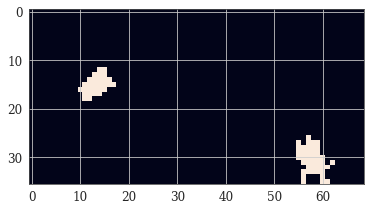

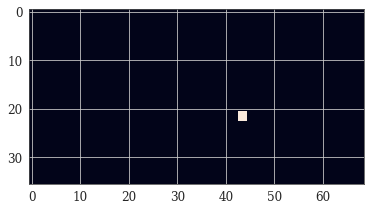

In [73]:
predicted_events = weighted_metric > 1

plt.imshow(predicted_events[:, :, 965])
plt.show()
plt.imshow(cyclone_events[:, :, 965])

In [70]:
np.flatnonzero(np.sum(cyclone_events, axis=(0, 1)))

array([   961,    962,    963, ..., 113744, 113745, 113746], dtype=int64)

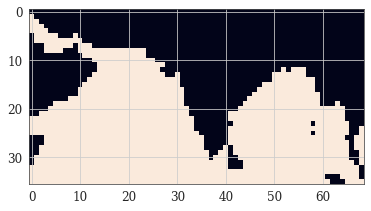

In [35]:
plt.imshow(available_mask)